In [2]:
import os
import random
import csv

## **Data Preperation**

In [3]:
underwater_img_dir = r'/kaggle/input/uieb-dataset-raw/raw-890'
groundtruth_img_dir = r'/kaggle/input/uieb-dataset-reference/reference-890'

In [4]:
underwater_img_paths = []
groundtruth_img_paths = []

for folder_name1 in os.listdir(underwater_img_dir):
    underwater_img_path = os.path.join(underwater_img_dir,folder_name1)
    underwater_img_paths.append(underwater_img_path)

for folder_name2 in os.listdir(underwater_img_dir):
    groundtruth_img_path = os.path.join(groundtruth_img_dir,folder_name2)
    groundtruth_img_paths.append(groundtruth_img_path)


In [5]:
underwater_img_paths = sorted(underwater_img_paths)
groundtruth_img_paths = sorted(groundtruth_img_paths)

**Train Validation Test Split**

In [6]:
TRAIN_SPLIT      = 0.8
VALIDATION_SPLIT = 0.1
TEST_SPLIT       = 0.1

In [7]:
# Combine the groundtruth and noise image paths into tuples
image_pairs = list(zip(underwater_img_paths,groundtruth_img_paths))

# Shuffle the image pairs randomly
random.shuffle(image_pairs)

# Calculate the number of samples for each split based on the ratios
total_samples = len(image_pairs)
train_samples = int(TRAIN_SPLIT * total_samples)
val_samples = int(VALIDATION_SPLIT * total_samples)
test_samples = total_samples - train_samples - val_samples

# Split the data into train, validation, and test sets
train_data = image_pairs[:train_samples]
val_data = image_pairs[train_samples:train_samples + val_samples]
test_data = image_pairs[train_samples + val_samples:]

**save image paths as csv files for easy data loading**

In [8]:
# Save the data into separate CSV files
def save_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['UnderWater Images', 'GroundTruth Images'])
        writer.writerows(data)

save_to_csv('train.csv', train_data)
save_to_csv('validation.csv', val_data)
save_to_csv('test.csv', test_data)

# **Training LLE_UNET**

In [9]:
import cv2
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import random


import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Concatenate, GlobalAveragePooling2D, Multiply,GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB7


In [10]:
tf.__version__

'2.13.0'

**Padding Mechanism**

In [11]:
def padding_calc(input_dim,multiplier=32):
    return math.ceil(input_dim/multiplier)*multiplier - input_dim

# Add Padding
def pad_image(image,mood = "center_padding"):
    img_h = image.shape[0]
    img_w = image.shape[1]

    pad_y = padding_calc(img_h)
    pad_x = padding_calc(img_w)

    if mood == "center_padding":
        pad_y2 = pad_y//2
        pad_x2 = pad_x//2

        padded_img = image.copy()
        if pad_y%2 != 0:
            padded_img = np.pad(image, ((pad_y2, pad_y2+1), (pad_x2, pad_x2), (0, 0)), mode='constant')
        if pad_x%2 != 0:
            padded_img = np.pad(image, ((pad_y2, pad_y2), (pad_x2, pad_x2+1), (0, 0)), mode='constant')
        if (pad_y%2 == 0) & (pad_x%2 == 0):
            padded_img = np.pad(image, ((pad_y2, pad_y2), (pad_x2, pad_x2), (0, 0)), mode='constant')

    elif mood == "corner_padding":
        padded_img = np.pad(image, ((0, pad_y), (0, pad_x), (0, 0)), mode='constant')
    return padded_img

# Remove Padding
def inverse_padding(pad_image,image_dim,pad_method="center_padding"):
  pad_img_height = pad_image.shape[0]
  pad_img_width = pad_image.shape[1]

  img_height = image_dim[0]
  img_width = image_dim[1]

  if pad_method == "center_padding":
    pad_y1 = (pad_img_height - img_height)//2
    if pad_y1*2 == (pad_img_height - img_height):pad_y2 = pad_y1
    else: pad_y2 = pad_y1+1

    pad_x1 = (pad_img_width - img_width)//2
    if pad_x1*2 == (pad_img_width - img_width):pad_x2 = pad_x1
    else: pad_x2 = pad_x1+1
    extract_image = pad_image[pad_y1:pad_img_height-pad_y2,pad_x1:pad_img_width-pad_x2]

  if pad_method == "corner_padding":
    extract_image = pad_image[0:img_height,0:img_width]


  return extract_image

In [12]:
# set Random Seed
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(True)

In [13]:
## test image padding mechanism
test_H = 300
test_W = 533
test_image = np.zeros((test_H, test_W, 3), dtype=np.uint8)
img_pad = pad_image(test_image,'center_padding')
print(test_image.shape,img_pad.shape)

(300, 533, 3) (320, 544, 3)


In [14]:
# Load train test validation image paths form csv files 
def load_excel_data(file_path, column1_name='UnderWater Images', column2_name='GroundTruth Images', sheet_name="Sheet1"):
    try:
        # Load the Excel file
        df = pd.read_csv(file_path)

        # Extract the data from the specified columns
        column1_data = df[column1_name].tolist()
        column2_data = df[column2_name].tolist()

        return column1_data, column2_data

    except Exception as e:
        print(f"Error occurred while loading data from Excel: {e}")
        return None, None

In [15]:
train_csv_path = r'/kaggle/working/train.csv'
test_csv_path = r'/kaggle/working/test.csv'
validation_csv_path = r'/kaggle/working/validation.csv'


train_x_paths, train_y_paths = load_excel_data(train_csv_path)
val_x_paths, val_y_paths = load_excel_data(validation_csv_path)
test_x_paths, test_y_paths = load_excel_data(test_csv_path)

In [16]:
train_x_paths = sorted(train_x_paths)
train_y_paths = sorted(train_y_paths)
val_x_paths = sorted(val_x_paths)
val_y_paths = sorted(val_y_paths)
test_x_paths = sorted(test_x_paths)
test_y_paths = sorted(test_y_paths)

In [17]:
print(f'X_train : {len(train_x_paths)}')
print(f'Y_train : {len(train_y_paths)}')
print(f'X_val   : {len(val_x_paths)}')
print(f'Y_val   : {len(val_y_paths)}')
print(f'X_test  : {len(test_x_paths)}')
print(f'Y_test  : {len(test_y_paths)}')

X_train : 712
Y_train : 712
X_val   : 89
Y_val   : 89
X_test  : 89
Y_test  : 89


In [18]:
@tf.function
def load_image_file(file_path):
    file_path = file_path.numpy().decode("utf-8")
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    # img = cv2.resize(img,(0,0),fx=0.5, fy=0.5)
    preprocess_img = pad_image(img)
    preprocess_img = preprocess_img/255
    return preprocess_img

def image_dataset(image_list):
    files = tf.data.Dataset.from_tensor_slices(image_list)
    dataset = files.map(lambda x: tf.py_function(load_image_file, [x], tf.float32))
    return dataset

In [19]:
BATCH_SIZE = 8

In [20]:
train_x = image_dataset(list(train_x_paths))
train_y = image_dataset(list(train_y_paths))


# combine input and output
train = tf.data.Dataset.zip((train_x, train_y))
# train = train.take(100)
# train = train.shuffle(100)
train = train.batch(BATCH_SIZE)
train.prefetch(tf.data.AUTOTUNE)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [21]:
val_x = image_dataset(list(val_x_paths))
val_y = image_dataset(list(val_y_paths))

# combine input and output
val = tf.data.Dataset.zip((val_x, val_y))
# train = train.shuffle(100)
val = val.batch(BATCH_SIZE)
val.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [22]:
test_x = image_dataset(list(test_x_paths))
test_y = image_dataset(list(test_y_paths))

# combine input and output
test = tf.data.Dataset.zip((test_x, test_y))
# test = test.shuffle(100)
test = test.batch(BATCH_SIZE)
test.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

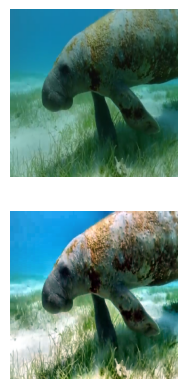

In [23]:
sample = train.take(2)
train_sample = sample.as_numpy_iterator()
res = train_sample.next()
i=1
underwater_img1 = res[0][i]
groundtruth_img1 = res[1][i]

fig, axs = plt.subplots(nrows=2);
axs[0].imshow(underwater_img1);
axs[1].imshow(groundtruth_img1);
axs[0].axis('off');
axs[1].axis('off');

### **UWE-NET**

*CBAM Attention*

In [24]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape

    ## Shared layers
    l1 = Dense(channel//ratio, activation="elu", use_bias=False)
    l2 = Dense(channel, use_bias=False)

    ## Global Average Pooling
    x1 = GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)

    ## Global Max Pooling
    x2 = GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)

    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = Activation("sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)

    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)

    ## Concatenat both the features
    feats = Concatenate()([x1, x2])
    ## Conv layer
    feats = Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = Multiply()([x, feats])

    return feats

def CBAM(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

## **UWE-NET Blocks**

In [25]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_model(input_shape):
    inputs = Input(input_shape)

    vgg_model = VGG16(include_top=False, weights="imagenet",input_tensor=inputs)
    vgg_model.trainable = True

    # Encoder
    s1 = vgg_model.get_layer("block1_conv2").output                             ## (512 x 512)
    s2 = vgg_model.get_layer("block2_conv2").output                             ## (256 x 256)
    s3 = vgg_model.get_layer("block3_conv3").output                             ## (128 x 128)
    s4 = vgg_model.get_layer("block4_conv3").output                             ## (64 x 64)

    b1 = vgg_model.get_layer("block5_conv3").output                             ## (32 x 32)

    # Attention
    s1 = CBAM(s1)
    s2 = CBAM(s2)
    s3 = CBAM(s3)
    s4 = CBAM(s4)
#     b1 = CBAM(b1)
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)                                             ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                                             ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                                             ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                                              ## (512 x 512)

    # Output
    outputs = Conv2D(3, 1, padding="same", activation="hard_sigmoid")(d4)

    model = Model(inputs, outputs, name="VG_UNET_undwerwater")
    return model


In [26]:
input_shape = (None, None, 3)
model = build_model(input_shape)
# model.summary()

58889256/58889256 [==============================] - 3s 0us/step


In [27]:
print("trainable_weights:", len(model.trainable_weights))
print("non_trainable_weights:", len(model.non_trainable_weights))

trainable_weights: 84
non_trainable_weights: 16


In [28]:
#optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001,weight_decay=0.004)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
MSEloss = tf.keras.losses.MeanSquaredError()

def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def psnr_loss_fn(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=1.0)

def ssim_loss_fn(y_true,y_pred):
    return tf.image.ssim(y_true,y_pred,1.0)

**Tensorflow callabck**

In [29]:
from keras.callbacks import ModelCheckpoint

# tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

**save_best_model_callback**

In [30]:
from datetime import datetime
model_save_folder = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_dir = f'models/{model_save_folder}'
#model_save_dir = f'models'

if not os.path.exists(model_save_dir):
  print("FOLDER CREATED")
  os.makedirs(model_save_dir)

save_best_model_checkpoint = ModelCheckpoint(model_save_dir+'/model-{epoch:03d}.hdf5',monitor='val_psnr_loss_fn',save_best_only=True,mode='auto')

FOLDER CREATED


In [31]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20240320_110813'

In [32]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    preprocess_img = pad_image(img)
    preprocess_img = preprocess_img/255;
    return preprocess_img

In [33]:
def infer(x_paths,y_paths,n_images=3):
    for i,x_image_path in enumerate(x_paths):
        if i == n_images:
            break
        print(f'{i+1}/{n_images} : {x_image_path}')
        x_img = preprocess_image(x_image_path)
        prediction = model.predict(np.expand_dims(x_img,axis=0),verbose=0)

        y_img_path = y_paths[i]
        y_img = preprocess_image(y_img_path)

        fig, ax = plt.subplots(ncols=3, figsize=(15,10));
        ax[0].imshow(x_img);
        ax[1].imshow(prediction[0]);
        ax[2].imshow(y_img);
        ax[0].axis('off');
        ax[1].axis('off');
        ax[2].axis('off');
        ax[0].set_title("UnderWater Image")
        ax[1].set_title("Predicted Image")
        ax[2].set_title("GroundTruth Image")
        plt.show()

In [34]:
from tensorflow.keras import callbacks
class PredictionCallback(callbacks.Callback):
    def __init__(self, log_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        #self.image_files = image_files
        self.log_interval = log_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.log_interval == 0:
            infer(train_x_paths,train_y_paths,n_images=2)


In [35]:
#model.compile(optimizer,loss, metrics = [charbonnier_loss,psnr_loss_fn,ssim_loss_fn])
model.compile(optimizer,charbonnier_loss, metrics = [MSEloss,psnr_loss_fn,ssim_loss_fn])

**Train Model**

In [36]:
LOG_INTERVALS = 5
EPOCHS        = 30

In [37]:
# # Train for 50 epochs

# hist = model.fit(train, epochs = EPOCHS, validation_data = val, callbacks=[tensorboard_callback,save_best_model_checkpoint,
#                                                                         PredictionCallback(log_interval = LOG_INTERVALS)])

**Save weights**

In [ ]:
# # save weights
# model.save("UWE-NET_UNDERWATER.h5")

# # save entire model
# model.save('UWE-NET_UNDERWATER')

**Loss curves**

In [38]:
# plt.plot(hist.history['loss'], color='teal', label='loss')
# plt.plot(hist.history['val_loss'], color='orange', label='val loss')
# plt.suptitle('Loss')
# plt.legend()
# plt.show()

**Tensorboard Visulaization**

In [42]:
%load_ext tensorboard

In [43]:
%tensorboard --logdir '/kaggle/working/logs'

**Model Inference on test data**

In [39]:
from keras.models import load_model

In [40]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

In [41]:

import tensorflow as tf
import keras.losses
keras.losses.charbonnier_loss = charbonnier_loss

In [42]:
#change the path with your downloaded path
new_model = tf.keras.models.load_model('/kaggle/input/uwe-net-model/UWE-NET_UNDERWATER (3).h5',compile=False)

In [43]:
new_model.summary()

Model: "VG_UNET_undwerwater"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                

In [44]:
def infer_test(x_paths,y_paths,n_images=2):
    for i,x_image_path in enumerate(x_paths):
        if i == n_images:
            break
        print(f'{i+1}/{n_images} : {x_image_path}')
        x_img = preprocess_image(x_image_path)
        prediction = new_model.predict(np.expand_dims(x_img,axis=0),verbose=0)

        y_img_path = y_paths[i]
        y_img = preprocess_image(y_img_path)

        fig, ax = plt.subplots(ncols=3, figsize=(15,10));
        ax[0].imshow(x_img);
        ax[1].imshow(prediction[0]);
        ax[2].imshow(y_img);
        ax[0].axis('off');
        ax[1].axis('off');
        ax[2].axis('off');
        ax[0].set_title("UnderWater Image")
        ax[1].set_title("Predicted Image")
        ax[2].set_title("GroundTruth Image")
        plt.show()

1/10 : /kaggle/input/uieb-dataset-raw/raw-890/10_img_.png


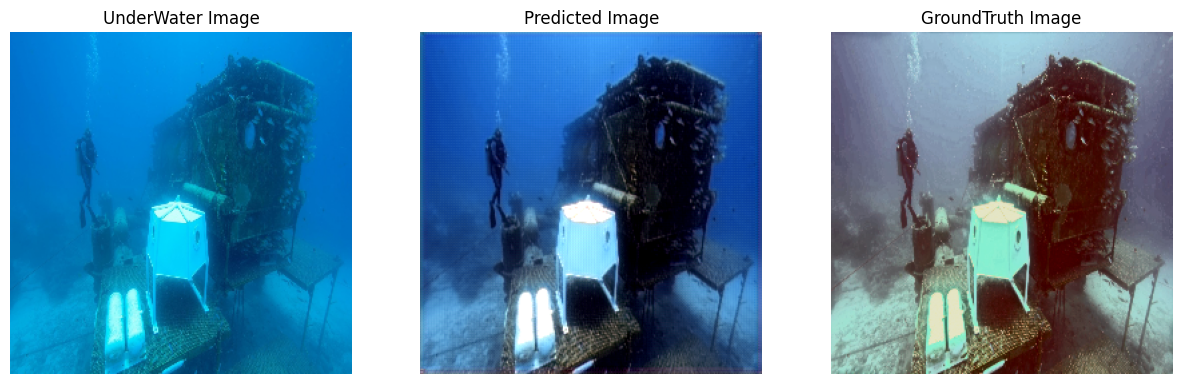

2/10 : /kaggle/input/uieb-dataset-raw/raw-890/111_img_.png


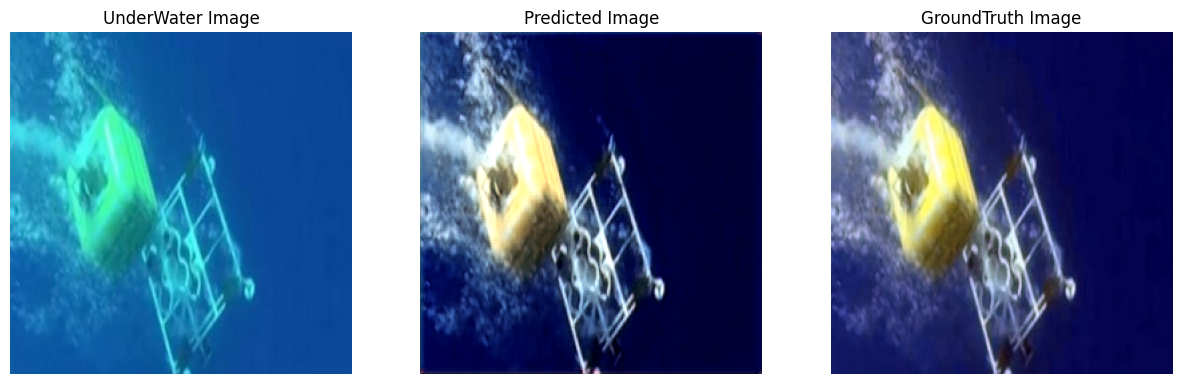

3/10 : /kaggle/input/uieb-dataset-raw/raw-890/115_img_.png


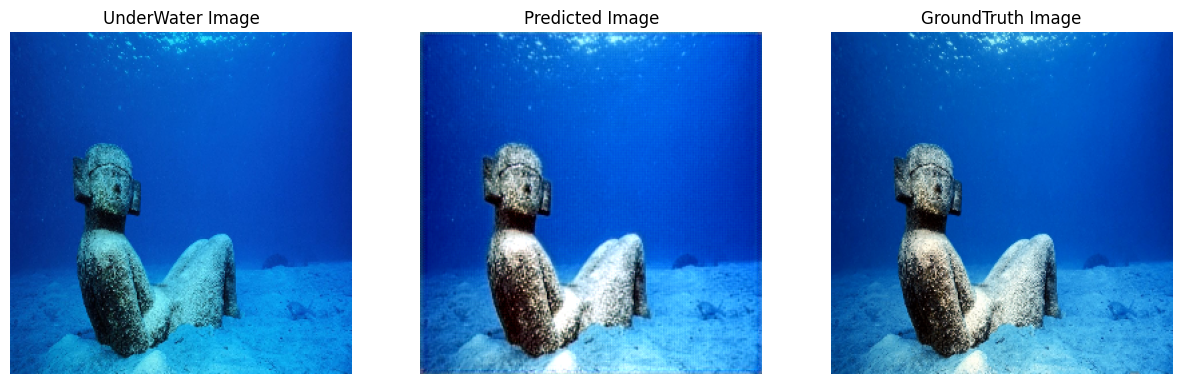

4/10 : /kaggle/input/uieb-dataset-raw/raw-890/12422.png


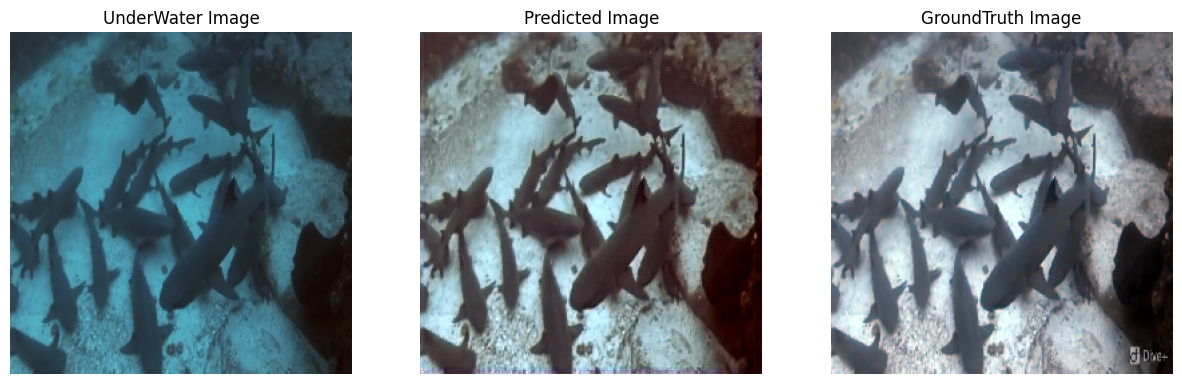

5/10 : /kaggle/input/uieb-dataset-raw/raw-890/12445.png


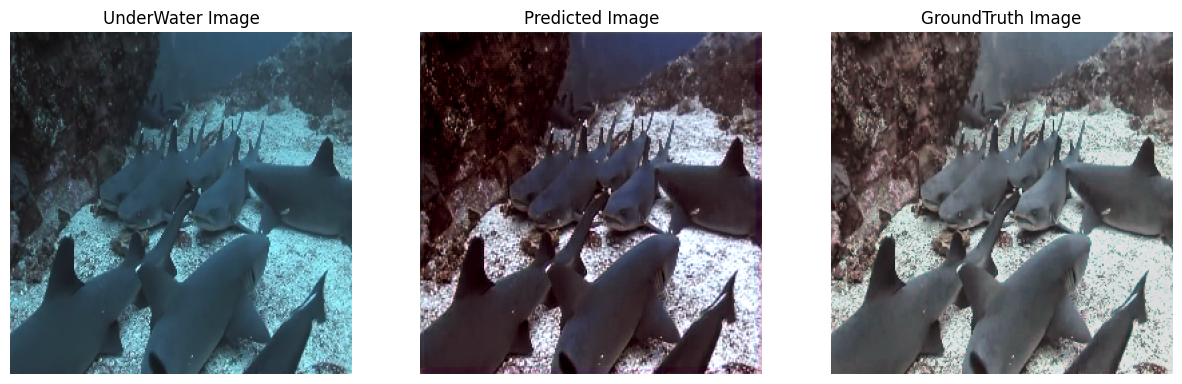

6/10 : /kaggle/input/uieb-dataset-raw/raw-890/130_img_.png


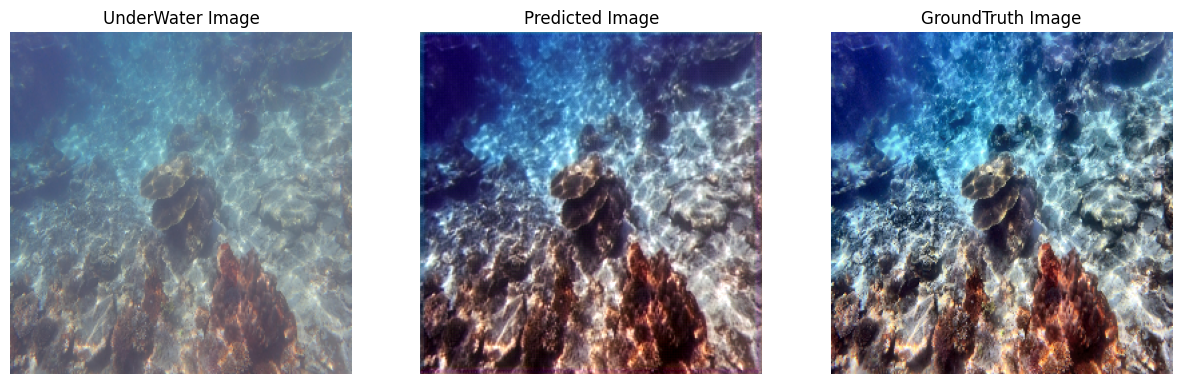

7/10 : /kaggle/input/uieb-dataset-raw/raw-890/137_img_.png


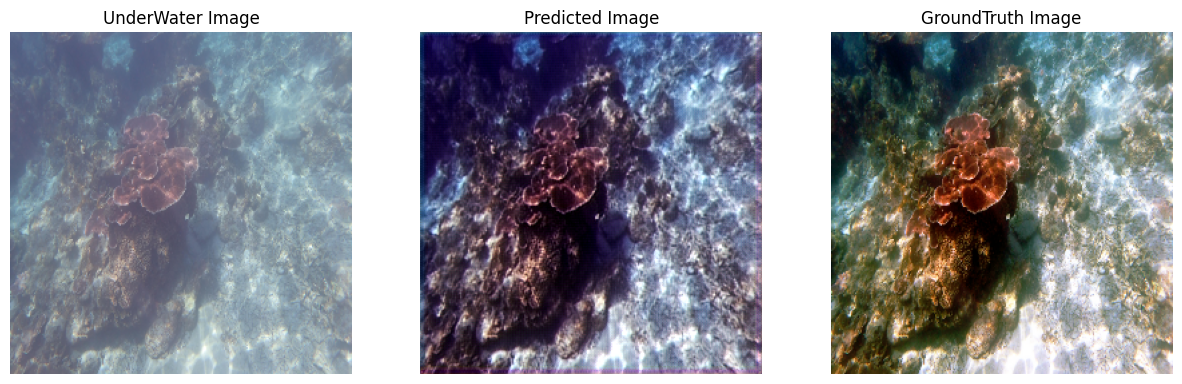

8/10 : /kaggle/input/uieb-dataset-raw/raw-890/143_img_.png


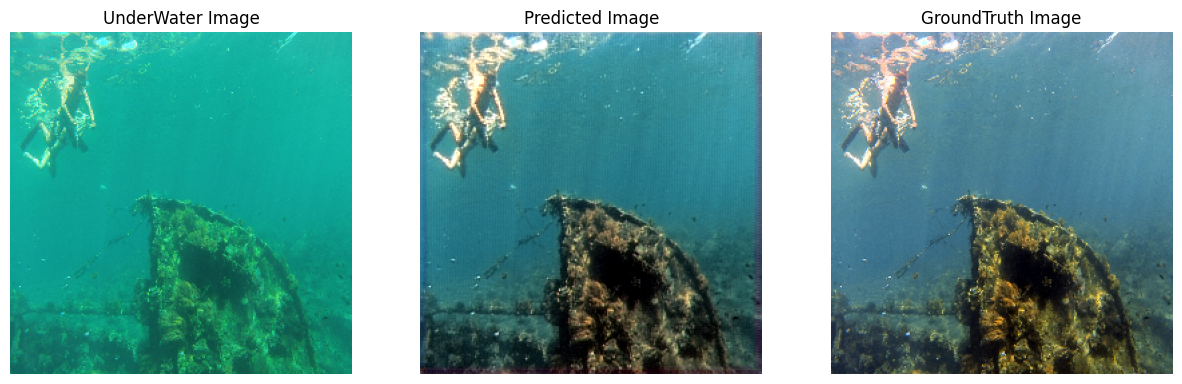

9/10 : /kaggle/input/uieb-dataset-raw/raw-890/145_img_.png


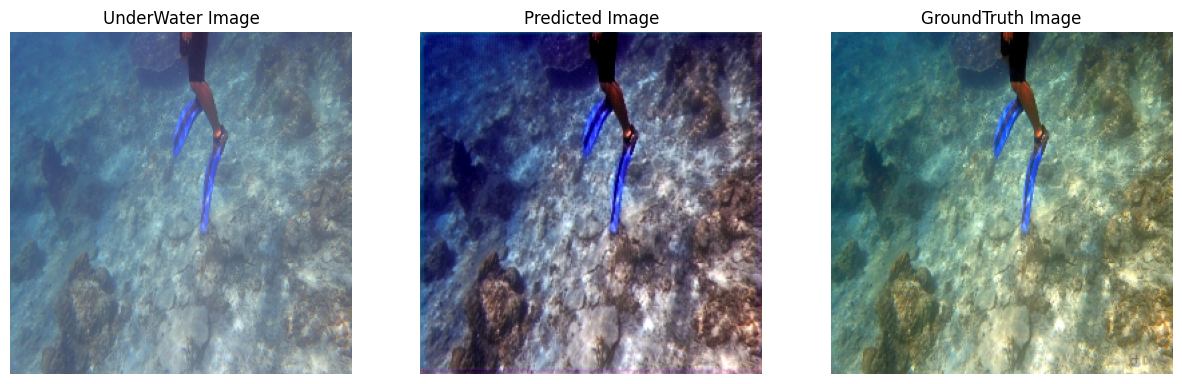

10/10 : /kaggle/input/uieb-dataset-raw/raw-890/15136.png


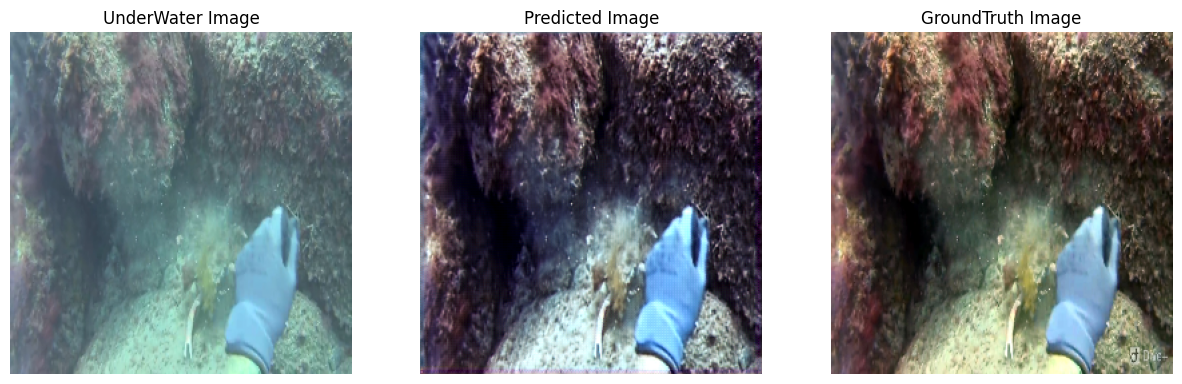

In [45]:
infer_test(test_x_paths,test_y_paths,n_images=10)

In [46]:
import os
testing = r'/kaggle/input/testing'

testing_paths = []

for folder_name1 in os.listdir(testing):
    testing_path = os.path.join(testing,folder_name1)
    testing_paths.append(testing_path)

In [47]:
image_test_pairs = list(zip(testing_paths,testing_paths))

In [48]:
import csv
def save_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['UnderWater Images', 'GroundTruth Images'])
        writer.writerows(data)

save_to_csv('testing.csv', image_test_pairs)

In [49]:
testing_x_paths, testing_y_paths = load_excel_data('/kaggle/working/testing.csv')

In [50]:
testing_x_paths = sorted(testing_x_paths)
testing_y_paths = sorted(testing_y_paths)

In [51]:
testing_x = image_dataset(list(testing_x_paths))
testing_y = image_dataset(list(testing_y_paths))

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [52]:
testing = tf.data.Dataset.zip((testing_x, testing_y))
# test = test.shuffle(100)
testing = testing.batch(8)
testing.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

1/2 : /kaggle/input/testing/test1.png


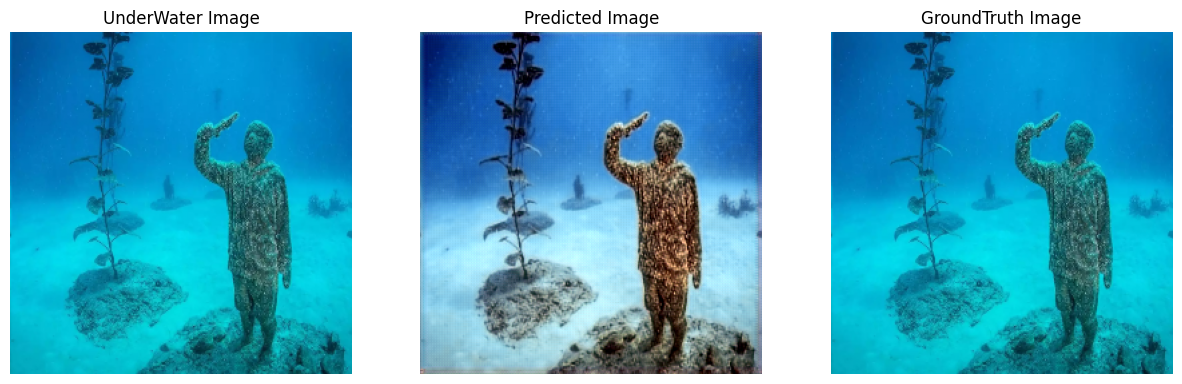

2/2 : /kaggle/input/testing/test2.png


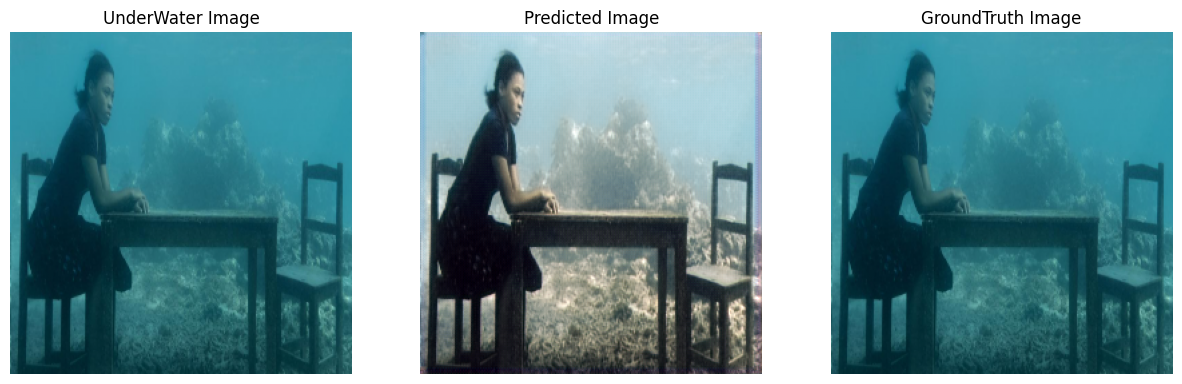

In [53]:
infer_test(testing_x_paths,testing_y_paths,n_images=2)

In [54]:
def infer_store(x_paths,n_images=2):
    for i,x_image_path in enumerate(x_paths):
        if i == n_images:
            break
        print(f'{i+1}/{n_images} : {x_image_path}')
        x_img = preprocess_image(x_image_path)
        prediction = new_model.predict(np.expand_dims(x_img,axis=0),verbose=0)
        enhanced_images.append(prediction[0])

        

In [55]:
def infer_store1(x_paths,n_images=2):
    for i,x_image_path in enumerate(x_paths):
        if i == n_images:
            break
        print(f'{i+1}/{n_images} : {x_image_path}')
        x_img = preprocess_image(x_image_path)
        or_images.append(x_img)

        

In [56]:
import numpy as np
import math
import sys
from skimage import io, color, filters
import os
import math

In [57]:
def calculate_UIQM(image):
    # Calculate mean, variance, and entropy of the image
    mean = np.mean(image)
    variance = np.var(image)
    entropy = -np.sum(np.multiply(image, np.log2(image + 1e-10)))

    # Calculate contrast
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray_image) ** 2

    # Calculate brightness
    brightness = np.mean(gray_image)

    # Calculate saturation
    r, g, b = cv2.split(image.astype(float))
    rg = r - g
    yb = 0.5 * (r + g) - b
    saturation = np.mean(np.sqrt(rg ** 2 + yb ** 2))

    # Calculate UIQM
    uiqm = (0.0282 * contrast) + (0.2953 * brightness) + (3.5753 * saturation) - (0.0027 * entropy) - (1.5402 * mean) - (0.0228 * variance)

    return uiqm

def calculate_UCIQE(image):
    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Calculate mean and standard deviation of each channel
    L, a, b = cv2.split(lab_image)
    L_mean = np.mean(L)
    L_std = np.std(L)
    a_mean = np.mean(a)
    a_std = np.std(a)
    b_mean = np.mean(b)
    b_std = np.std(b)

    # Calculate UCIQE
    uciqe = (0.4680 * L_mean) - (0.3802 * L_std) + (0.9048 * a_mean) + (0.9151 * a_std) + (1.2500 * b_mean) + (0.9965 * b_std)

    return uciqe


In [58]:
from scipy import ndimage
from PIL import Image
import numpy as np
import math


def _uiconm(x, window_size):
    """
      Underwater image contrast measure
      https://github.com/tkrahn108/UIQM/blob/master/src/uiconm.cpp
      https://ieeexplore.ieee.org/abstract/document/5609219
    """
    plip_lambda = 1026.0
    plip_gamma  = 1026.0
    plip_beta   = 1.0
    plip_mu     = 1026.0
    plip_k      = 1026.0
    # if 4 blocks, then 2x2...etc.
    k1 = x.shape[1]/window_size
    k2 = x.shape[0]/window_size
    # weight
    w = -1./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[0:int(blocksize_y*k2), 0:int(blocksize_x*k1)]
    # entropy scale - higher helps with randomness
    alpha = 1
    val = 0
    k1 = int(k1)
    k2 = int(k2)
    for l in range(k1):
        for k in range(k2):
            block = x[k*window_size:window_size*(k+1), l*window_size:window_size*(l+1), :]
            max_ = np.max(block)
            min_ = np.min(block)
            top = max_-min_
            bot = max_+min_
            if math.isnan(top) or math.isnan(bot) or bot == 0.0 or top == 0.0: val += 0.0
            else: val += alpha*math.pow((top/bot),alpha) * math.log(top/bot)
            #try: val += plip_multiplication((top/bot),math.log(top/bot))
    return w*val

def mu_a(x, alpha_L=0.1, alpha_R=0.1):
    """
      Calculates the asymetric alpha-trimmed mean
    """
    # sort pixels by intensity - for clipping
    x = sorted(x)
    # get number of pixels
    K = len(x)
    # calculate T alpha L and T alpha R
    T_a_L = math.ceil(alpha_L*K)
    T_a_R = math.floor(alpha_R*K)
    # calculate mu_alpha weight
    weight = (1/(K-T_a_L-T_a_R))
    # loop through flattened image starting at T_a_L+1 and ending at K-T_a_R
    s   = int(T_a_L+1)
    e   = int(K-T_a_R)
    val = sum(x[s:e])
    val = weight*val
    return val

def s_a(x, mu):
    val = 0
    for pixel in x:
        val += math.pow((pixel-mu), 2)
    return val/len(x)


def _uicm(x):
    R = x[:,:,0].flatten()
    G = x[:,:,1].flatten()
    B = x[:,:,2].flatten()
    RG = R-G
    YB = ((R+G)/2)-B
    mu_a_RG = mu_a(RG)
    mu_a_YB = mu_a(YB)
    s_a_RG = s_a(RG, mu_a_RG)
    s_a_YB = s_a(YB, mu_a_YB)
    l = math.sqrt( (math.pow(mu_a_RG,2)+math.pow(mu_a_YB,2)) )
    r = math.sqrt(s_a_RG+s_a_YB)
    return (-0.0268*l)+(0.1586*r)


def sobel(x):
    dx = ndimage.sobel(x,0)
    dy = ndimage.sobel(x,1)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag) 
    return mag

def _uism(x):
    """
      Underwater Image Sharpness Measure
    """
    # get image channels
    R = x[:,:,0]
    G = x[:,:,1]
    B = x[:,:,2]
    # first apply Sobel edge detector to each RGB component
    Rs = sobel(R)
    Gs = sobel(G)
    Bs = sobel(B)
    # multiply the edges detected for each channel by the channel itself
    R_edge_map = np.multiply(Rs, R)
    G_edge_map = np.multiply(Gs, G)
    B_edge_map = np.multiply(Bs, B)
    # get eme for each channel
    r_eme = eme(R_edge_map, 10)
    g_eme = eme(G_edge_map, 10)
    b_eme = eme(B_edge_map, 10)
    # coefficients
    lambda_r = 0.299
    lambda_g = 0.587
    lambda_b = 0.144
    return (lambda_r*r_eme) + (lambda_g*g_eme) + (lambda_b*b_eme)


def eme(x, window_size):
    """
      Enhancement measure estimation
      x.shape[0] = height
      x.shape[1] = width
    """
    # if 4 blocks, then 2x2...etc.
    k1 = x.shape[1]/window_size
    k2 = x.shape[0]/window_size
    # weight
    w = 2./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[0:int(blocksize_y*k2), 0:int(blocksize_x*k1)]
    val = 0
    k1 = int(k1)
    k2 = int(k2)
    for l in range(k1):
        for k in range(k2):
            block = x[k*window_size:window_size*(k+1), l*window_size:window_size*(l+1)]
            max_ = np.max(block)
            min_ = np.min(block)
            # bound checks, can't do log(0)
            if min_ == 0.0: val += 0
            elif max_ == 0.0: val += 0
            else: val += math.log(max_/min_)
    return w*val



def getUIQM(x):
    """
      Function to return UIQM to be called from other programs
      x: image
    """
    x = x.astype(np.float32)
    ### UCIQE: https://ieeexplore.ieee.org/abstract/document/7300447
    #c1 = 0.4680; c2 = 0.2745; c3 = 0.2576
    ### UIQM https://ieeexplore.ieee.org/abstract/document/7305804
    c1 = 0.0282; c2 = 0.2953; c3 = 3.5753
    uicm   = _uicm(x)
    uism   = _uism(x)
    uiconm = _uiconm(x, 10)
    uiqm = (c1*uicm) + (c2*uism) + (c3*uiconm)
    return uiqm

In [59]:
def uciqe(image):
    image = image.astype(np.float32)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # RGB转为HSV
    H, S, V = cv2.split(hsv)
    delta = np.std(H) / 180  # 色度的标准差
    mu = np.mean(S) / 255  # 饱和度的平均值
    n, m = np.shape(V)
    number = math.floor(n * m / 100)  # 所需像素的个数
    Maxsum, Minsum = 0, 0
    V1, V2 = V / 255, V / 255

    for i in range(1, number + 1):
        Maxvalue = np.amax(np.amax(V1))
        x, y = np.where(V1 == Maxvalue)
        Maxsum = Maxsum + V1[x[0], y[0]]
        V1[x[0], y[0]] = 0

    top = Maxsum / number

    for i in range(1, number + 1):
        Minvalue = np.amin(np.amin(V2))
        X, Y = np.where(V2 == Minvalue)
        Minsum = Minsum + V2[X[0], Y[0]]
        V2[X[0], Y[0]] = 1

    bottom = Minsum / number

    conl = top - bottom
    ###对比度
    uciqe = 0.4680 * delta + 0.2745 * conl + 0.2575 * mu
    
    return uciqe


In [60]:
enhanced_images = []
or_images = []

infer_store(test_x_paths,len(test_x_paths))
infer_store1(test_y_paths,len(test_y_paths))

1/89 : /kaggle/input/uieb-dataset-raw/raw-890/10_img_.png
2/89 : /kaggle/input/uieb-dataset-raw/raw-890/111_img_.png


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/89 : /kaggle/input/uieb-dataset-raw/raw-890/115_img_.png
4/89 : /kaggle/input/uieb-dataset-raw/raw-890/12422.png
5/89 : /kaggle/input/uieb-dataset-raw/raw-890/12445.png
6/89 : /kaggle/input/uieb-dataset-raw/raw-890/130_img_.png
7/89 : /kaggle/input/uieb-dataset-raw/raw-890/137_img_.png
8/89 : /kaggle/input/uieb-dataset-raw/raw-890/143_img_.png
9/89 : /kaggle/input/uieb-dataset-raw/raw-890/145_img_.png
10/89 : /kaggle/input/uieb-dataset-raw/raw-890/15136.png
11/89 : /kaggle/input/uieb-dataset-raw/raw-890/164_img_.png
12/89 : /kaggle/input/uieb-dataset-raw/raw-890/165_img_.png
13/89 : /kaggle/input/uieb-dataset-raw/raw-890/169_img_.png
14/89 : /kaggle/input/uieb-dataset-raw/raw-890/1742.png
15/89 : /kaggle/input/uieb-dataset-raw/raw-890/175_img_.png
16/89 : /kaggle/input/uieb-dataset-raw/raw-890/189_img_.png
17/89 : /kaggle/input/uieb-dataset-raw/raw-890/195_img_.png
18/89 : /kaggle/input/uieb-dataset-raw/raw-890/196_img_.png
19/89 : /kaggle/input/uieb-dataset-raw/raw-890/223_img_.png


In [61]:
def show():
    
    N=0
    for i in range(len(or_images)):
        uiqm1 = getUIQM(or_images[i])
        uciq1 = uciqe(or_images[i])
        uiqm2 = getUIQM(enhanced_images[i])
        uciq2 = uciqe(enhanced_images[i])
        fig, ax = plt.subplots(ncols=2, figsize=(10,6));
        ax[0].imshow(or_images[i]);
        ax[1].imshow(enhanced_images[i]);
        ax[0].axis('off');
        ax[1].axis('off');
        ax[0].set_title("Ground Truth")
        ax[1].set_title("Enhanced Image")
        plt.show()
        print('Score-Original-{}: uiqm={} uciqe={}\n'.format(N,uiqm1, uciq1))
        print('Score-Enhanced-{}: uiqm={} uciqe={}\n'.format(N,uiqm2, uciq2))
        N +=1

In [62]:
# average UCIQUE and UIQM calculation
sumuiqm, sumuciqe = 0,0
N=0

for imgdir in enhanced_images:
    uiqm = getUIQM(imgdir)
    uciq = uciqe(imgdir)
    sumuiqm += uiqm
    sumuciqe += uciq
    #     print('Score-{}: uiqm={} uciqe={}\n'.format(N,uiqm, uciq))
    N +=1
    
muiqm = sumuiqm/N
muciqe = sumuciqe/N        
print('Average: uiqm={}\n'.format(muiqm, muciqe))

Average: uiqm=2.779480582912135



In [65]:
print('Average: uiqm={} uciqe={}\n'.format(muiqm, muciqe))

Average: uiqm=2.779480582912135 uciqe=0.19584184763651957

